In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

# import tunable_coupler as tc

In [5]:
# import numpy as np

def g_eff(wc, w1, w2, C1, C2, C12, C1c, C2c, Cc):
    """
    w in GHz and C in fF
    """
    eta = C1c*C2c/C12/Cc
    Sigma = 2 / (1/(w1+wc) + 1/(w2+wc))
    Delta = 2/(1/(w1-wc) + 1/(w2-wc))

    g = 1/2*(wc*eta/2/Delta - wc*eta/2/Sigma + eta + 1)* C12 *np.sqrt(w1*w2)/np.sqrt(C1*C2)
    
    return g

def g1(wc,w1,C1,C1c,Cc):
    """
    Qubit-coupler coupling strengh in GHz.
    C in fF
    """
    g1 = 1/2*C1c/np.sqrt(C1*Cc)*np.sqrt(w1*wc)
    
    return g1

def g2(wc,w2,C2,C2c,Cc):
    """
    Qubit-coupler coupling strengh in GHz.
    C in fF
    """
    g2 = 1/2*C2c/np.sqrt(C2*Cc)*np.sqrt(w2*wc)
    
    return g2

def g12(w1,w2,C1,C2,C12, C1c,C2c,Cc):
    """
    Qubit-qubit coupling strengh in GHz.
    C in fF
    """
    eta = C1c*C2c/C12/Cc
    g12 = 1/2*(1 + eta)*C12/np.sqrt(C1*C2)*np.sqrt(w1*w2)
    
    return g12


Text(0,0.5,'Coupling, 2g_eff (MHz)')

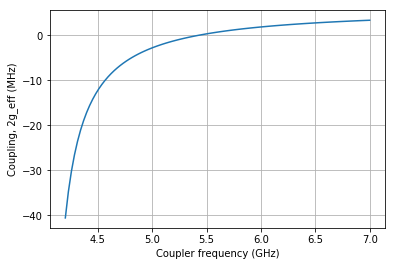

In [6]:
# parameters from Yan's paper
w1, w2 = 4, 4 # in GHz
(C1, C2, C12, C1c, C2c, Cc) = (70,72,0.1,4,4.2,200)

freq_c = np.linspace(4.2, 7, 101)
coupling = g_eff(freq_c,w1,w2,C1, C2,C12,C1c,C2c,Cc)

plt.plot(freq_c, 2*coupling*1e3)
plt.grid('on')
plt.xlabel('Coupler frequency (GHz)')
plt.ylabel('Coupling, 2g_eff (MHz)')

g1=141.4 MHz
g12=9.438 MHz


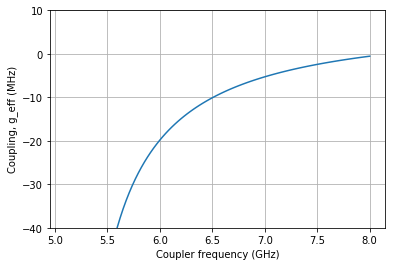

In [12]:
# parameters for IBM qubit
w1, w2 = 5, 5 # in GHz
(C1, C2, C12, C1c, C2c, Cc) = (70,72,0.1,4,4.2,100)
# (C1, C2, C12, C1c, C2c, Cc) = (60,60,0.10,10,14,100)

freq_c = np.linspace(5.1, 8, 101)
coupling = g_eff(freq_c,w1,w2,C1, C2,C12,C1c,C2c,Cc)
plt.plot(freq_c, 2*coupling*1e3)
plt.grid('on')
plt.xlabel('Coupler frequency (GHz)')
plt.ylabel('Coupling, g_eff (MHz)')
plt.ylim(-40, 10)

wc = 7
print(f'g1={g1(wc,w1,C1,C1c,Cc)*1e3:.1f} MHz')
print(f'g12={g12(w1,w2,C1,C2,C12,C1c,C2c,Cc)*1e3:.3f} MHz')

In [30]:
C1c*C2c/C12/Cc

1.12

Text(0,0.5,'Coupling, 2g1 (MHz)')

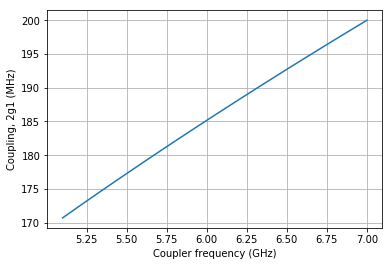

In [13]:
# parameters from Yan's paper
w1, w2 = 5, 5 # in GHz
(C1, C2, C12, C1c, C2c, Cc) = (70,72,0.1,4,4.2,200)

freq_c = np.linspace(5.1, 7, 101)

plt.plot(freq_c, 2*g1(freq_c,w1,C1,C1c,Cc)*1e3)
plt.grid('on')
plt.xlabel('Coupler frequency (GHz)')
plt.ylabel('Coupling, 2g1 (MHz)')

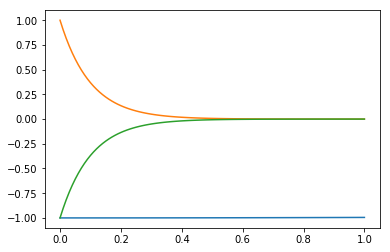

In [21]:
from math import pi

t=np.linspace(0, 1, 101)
y1= np.sin(0.1*t-pi/2)
y2 = np.exp(-t/0.1)
y3 = y1*y2
plt.plot(t, y1, t, y2, t, y3)